<a href="https://colab.research.google.com/github/MUbarak123-56/qiskit-work/blob/master/quantum_applications/qaoa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q qiskit
!pip install -q pylatexenc
!pip install git+https://github.com/qiskit-community/qiskit-textbook.git#subdirectory=qiskit-textbook-src

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 36.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.5/241.5 kB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 46.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.5/37.5 MB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.7/112.7 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━

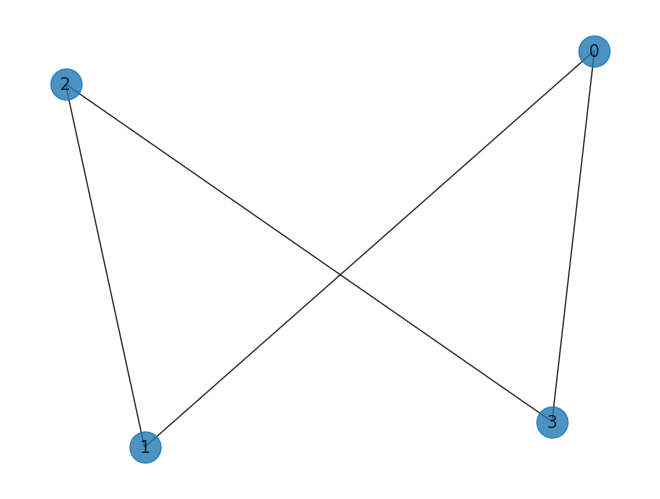

In [2]:
import networkx as nx
graph = nx.Graph()
graph.add_nodes_from([0,1,2,3])
graph.add_edges_from([(0,1), (1,2), (2,3), (3,0)])
nx.draw(graph, with_labels = True, alpha = 0.8, node_size = 500)

#### Mixing Unitary

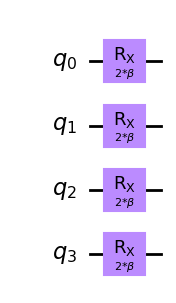

In [3]:
from qiskit import QuantumCircuit, Aer
from qiskit.circuit import Parameter

adjacency = nx.adjacency_matrix(graph).todense()

N_QUBITS = 4

beta = Parameter("$\\beta$")
qc_mix = QuantumCircuit(N_QUBITS)

for i in range(N_QUBITS):
  qc_mix.rx(2*beta, i)

qc_mix.draw("mpl")

#### Problem Unitary

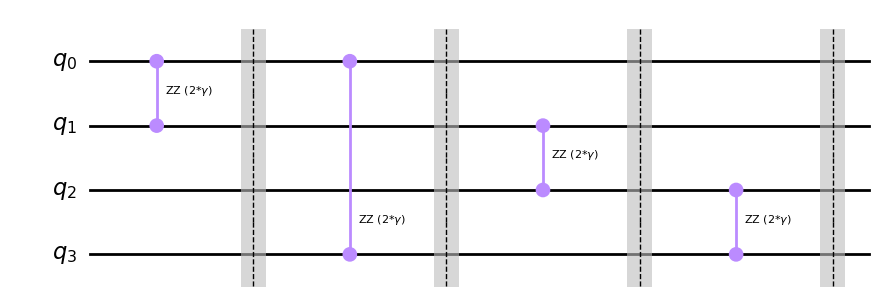

In [4]:
gamma = Parameter("$\\gamma$")

qc_p = QuantumCircuit(N_QUBITS)

for pair in list(graph.edges()):
  qc_p.rzz(2*gamma, pair[0], pair[1])
  qc_p.barrier()

qc_p.draw("mpl")

#### Initial State

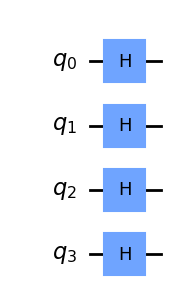

In [5]:
qc_0 = QuantumCircuit(N_QUBITS)

for i in range(N_QUBITS):
  qc_0.h(i)

qc_0.draw("mpl")

#### The QAOA Circuit

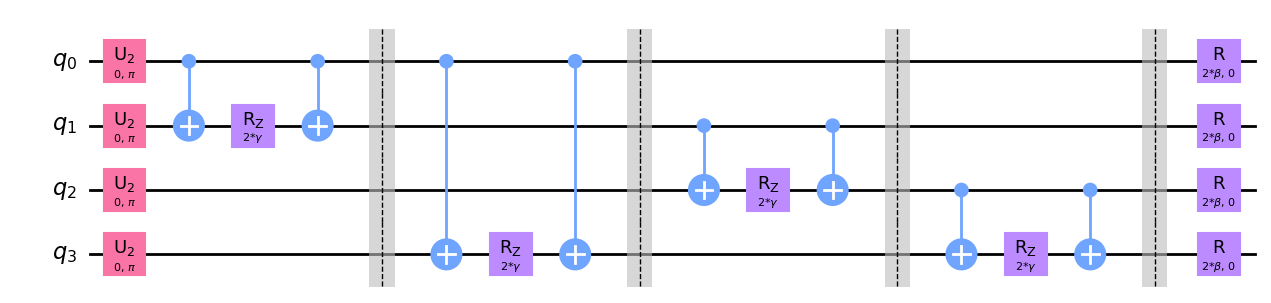

In [6]:
qc_qaoa = QuantumCircuit(N_QUBITS)

qc_qaoa.append(qc_0, range(N_QUBITS))
qc_qaoa.append(qc_p, range(N_QUBITS))
qc_qaoa.append(qc_mix, range(N_QUBITS))

qc_qaoa.decompose().decompose().draw("mpl")

In [7]:
def maxcut_obj(solution, graph):
    """Given a bit string as a solution, this function returns
    the number of edges shared between the two partitions
    of the graph.
    Args:
        solution: (str) solution bit string
        graph: networkx graph
    Returns:
        obj: (float) Objective
    """
    obj = 0
    for i, j in graph.edges():
        if solution[i] != solution[j]:
            obj -= 1
    return obj


def compute_expectation(counts, graph):
    """Computes expectation value based on measurement results
    Args:
        counts: (dict) key as bit string, val as count
        graph: networkx graph
    Returns:
        avg: float
             expectation value
    """
    avg = 0
    sum_count = 0
    for bit_string, count in counts.items():
        obj = maxcut_obj(bit_string, graph)
        avg += obj * count
        sum_count += count
    return avg/sum_count


# We will also bring the different circuit components that
# build the qaoa circuit under a single function
def create_qaoa_circ(graph, theta):
    """Creates a parametrized qaoa circuit
    Args:
        graph: networkx graph
        theta: (list) unitary parameters
    Returns:
        (QuantumCircuit) qiskit circuit
    """
    nqubits = len(graph.nodes())
    n_layers = len(theta)//2  # number of alternating unitaries
    beta = theta[:n_layers]
    gamma = theta[n_layers:]

    qc = QuantumCircuit(nqubits)

    # initial_state
    qc.h(range(nqubits))

    for layer_index in range(n_layers):
        # problem unitary
        for pair in list(graph.edges()):
            qc.rzz(2 * gamma[layer_index], pair[0], pair[1])
        # mixer unitary
        for qubit in range(nqubits):
            qc.rx(2 * beta[layer_index], qubit)

    qc.measure_all()
    return qc


# Finally we write a function that executes the circuit
# on the chosen backend
def get_expectation(graph, shots=512):
    """Runs parametrized circuit
    Args:
        graph: networkx graph
    """
    backend = Aer.get_backend('qasm_simulator')
    backend.shots = shots

    def execute_circ(theta):
        qc = create_qaoa_circ(graph, theta)
        counts = backend.run(qc, seed_simulator=10,
                             nshots=512).result().get_counts()
        return compute_expectation(counts, graph)

    return execute_circ

In [8]:
from scipy.optimize import minimize
expectation = get_expectation(graph)
res = minimize(expectation,
               [1.0, 1.0],
               method='COBYLA')
res

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -2.994140625
       x: [ 1.979e+00  1.167e+00]
    nfev: 30
   maxcv: 0.0

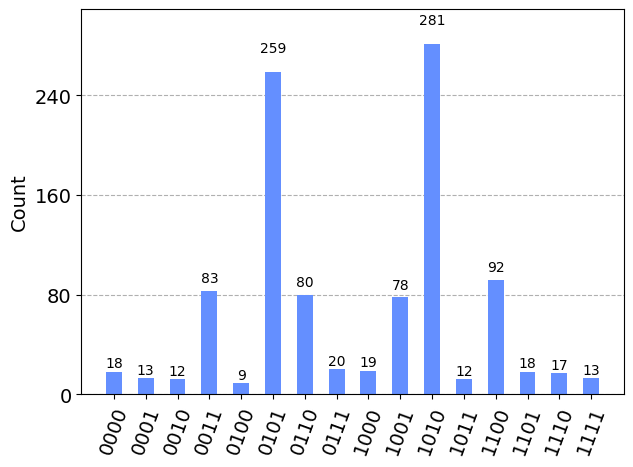

In [9]:
backend = Aer.get_backend('aer_simulator')
backend.shots = 512

from qiskit.visualization import plot_histogram
qc_res = create_qaoa_circ(graph, res.x)
counts = backend.run(qc_res, seed_simulator=10).result().get_counts()
plot_histogram(counts)